<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/Drone%20Prediction/MobilenetV2_SPP-Net_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Aug  7 03:50:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from pathlib import Path
import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Cutout)

drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
sys.path.append('/content/gdrive/My Drive/Session2')
os.chdir('/content/gdrive/My Drive/Session2')

In [ ]:
! pip install piexif
import piexif

In [4]:
 model1 = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [22]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value=0.02
class sppmob(nn.Module):
    def __init__(self):
        super(sppmob, self).__init__()
        count=1 
        for child in model1.children(): 
         if count==1:  
          self.conv1=child
          count=count+1 
          break;
        
        self.lin=nn.Linear(in_features=26880,out_features=4,bias=True)    
    

    def forward(self, x):
        x=self.conv1(x)
        spp=spatial_pyramid_pool(x,1,[int(x.size()[2]),int(x.size()[3])],[4,2,1])
        x=self.lin(spp)
        return x



In [23]:
model=sppmob().to("cuda")

In [24]:
import math
def spatial_pyramid_pool(previous_conv, num_sample, previous_conv_size, out_pool_size):
    '''
    previous_conv: a tensor vector of previous convolution layer
    num_sample: an int number of image in the batch
    previous_conv_size: an int vector [height, width] of the matrix features size of previous convolution layer
    out_pool_size: a int vector of expected output size of max pooling layer
    
    returns: a tensor vector with shape [1 x n] is the concentration of multi-level pooling
    '''   
    # print(previous_conv.size())
    for i in range(len(out_pool_size)):
        #print(previous_conv_size)
        h_wid = int(math.ceil(previous_conv_size[0] / out_pool_size[i]))
        w_wid = int(math.ceil(previous_conv_size[1] / out_pool_size[i]))
        h_pad = math.floor((h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2)
        w_pad = math.floor((w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2)
        zero_pad = torch.nn.ZeroPad2d((w_pad,w_pad,h_pad,h_pad))
        previous_conv = zero_pad(previous_conv)
        #update kernal
        h_new,w_new=previous_conv.size()[2:]

        h_wid=math.ceil(h_new/out_pool_size[i])

        w_wid=math.ceil(w_new/out_pool_size[i])

        #update stride:

        stride=(math.floor(h_new/out_pool_size[i]),math.floor(w_new/out_pool_size[i]))

        #maxpool = nn.MaxPool2d((h_wid,w_wid), stride=(h_wid, w_wid), padding=(h_pad, w_pad))
        
        maxpool = nn.MaxPool2d((h_wid,w_wid), stride=stride)
        x = maxpool(previous_conv)
        if(i == 0):
            spp = x.view(num_sample,-1)
            #print("spp size:",spp.size())
        else:
            #print("size:",spp.size())
            spp = torch.cat((spp,x.view(num_sample,-1)), 1)
    #print("size:",spp.size(),previous_conv_size)     
    return spp

In [ ]:
!pip install torchsummary
from torchsummary import summary
#summary(model.to('cuda'),input_size=(3,1588,256))

In [8]:
!7z x '/content/gdrive/My Drive/Session2/Session 2 Dataset.7z' -o'/content/data/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/Session2/                                            1 file, 2006710848 bytes (1914 MiB)

Extracting archive: /content/gdrive/My Drive/Session2/Session 2 Dataset.7z
--
Path = /content/gdrive/My Drive/Session2/Session 2 Dataset.7z
Type = 7z
Physical Size = 2006710848
Headers Size = 306080
Method = LZMA2:24
Solid = +
Blocks = 2

  0%      0% 22 - Session 2 Dataset/FlyBirds Canada/000020.jpg                                                        0% 34 - Session 2 Dataset/FlyBirds Canada/000035.jpg

In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [10]:

large_drones=[]
label=[]
bird_drones=[]
winged_drones=[]
drones=[]
import numpy as np
from PIL import Image

count=1  # to restrict the data to few thousand


# Getting the BG list and replicate each background to 4000 


for root_large_drones, dirs_large_drones, files_large_drones in os.walk("/content/data/Session 2 Dataset/Large QuadCopters/"):
   for name_large_drones in files_large_drones:
     check_for_Jpg=name_large_drones.split('.')
     if check_for_Jpg[-1].lower()=='jpg' or check_for_Jpg[-1].lower() =='jpeg':
      
        p= Image.open(root_large_drones +'/'+ name_large_drones)
        if p.mode == 'RGB':
         
         drones.append(root_large_drones +'/'+ name_large_drones)
         label.append(0)
     

for root_winged_drones, dirs_winged_drones, files_winged_drones in os.walk("/content/data/Session 2 Dataset/Winged Drones/"):
   for name_winged_drones in files_winged_drones:
     check_for_Jpg=name_winged_drones.split('.')
     if check_for_Jpg[-1].lower()=='jpg' or check_for_Jpg[-1].lower() =='jpeg':
        p= Image.open(root_winged_drones +'/'+ name_winged_drones)
        if p.mode == 'RGB': 
      
         drones.append(root_winged_drones +'/'+ name_winged_drones) 
         label.append(1)  

for root_bird_drones, dirs_bird_drones, files_bird_drones in os.walk("/content/data/Session 2 Dataset/Flying Birds/"):
   for name_bird_drones in files_bird_drones:
      check_for_Jpg=name_bird_drones.split('.')
      if check_for_Jpg[-1].lower()=='jpg' or check_for_Jpg[-1].lower() =='jpeg':
        p= Image.open(root_bird_drones +'/'+ name_bird_drones)
        if p.mode == 'RGB': 
                    
         drones.append(root_bird_drones +'/'+ name_bird_drones)   
         label.append(2)  
for root_bird_can_drones, dirs_bird_can_drones, files_bird_can_drones in os.walk("/content/data/Session 2 Dataset/FlyingBirds Canada/"):
   for name_bird_can_drones in files_bird_can_drones:
      check_for_Jpg=name_bird_can_drones.split('.')
      if check_for_Jpg[-1].lower()=='jpg' or check_for_Jpg[-1].lower() =='jpeg':
        p= Image.open(root_bird_can_drones +'/'+ name_bird_can_drones)
        if p.mode == 'RGB':
        
         drones.append(root_bird_can_drones +'/'+ name_bird_can_drones)   
         label.append(2) 

for root_small_drones, dirs_small_drones, files_small_drones in os.walk("/content/data/Session 2 Dataset/Small QuadCopters/"):
   for name_small_drones in files_small_drones:
     check_for_Jpg=name_small_drones.split('.')
     if check_for_Jpg[-1].lower()=='jpg' or check_for_Jpg[-1].lower() =='jpeg':
        p= Image.open(root_small_drones +'/'+ name_small_drones)
        if p.mode == 'RGB':
          
           drones.append(root_small_drones +'/'+ name_small_drones)   
           label.append(3)


In [ ]:
p= Image.open('/content/data/Session 2 Dataset/Large QuadCopters//OIPjJJ8SBkCUFJdnJMEL1vJjwHaDW.jpg')


326

In [15]:
tot_drones={}
tot_drones={'drones' : drones , 'labels' : label}


In [12]:
len(tot_drones['drones'])

17217

In [ ]:
import cv2
for count in range(len(tot_drones['drones'])):
 p= Image.open(tot_drones['drones'][count])
"
 #k=p.mode
 #if k != 'RGB':
 # print(tot_drones['drones'][count])


In [ ]:
#print('No of data in large drones list:',   len(large_drones))
#print('No of data in winged drones list:',   len(winged_drones))
#print('No of data in bird list:',   len(bird_drones))

No of data in fgbg list: 502


In [ ]:
tot_drones['labels'][17000]

3

In [11]:

drones_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ColorJitter(brightness=0.20, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-30,30),fill=(0)),
                                       #transforms.Grayscale(),
                                       transforms.ToTensor(),
                                      
                                       #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
drones_transform_1 = transforms.Compose([
                                       #transforms.Resize((224, 224)),
                                       transforms.ColorJitter(brightness=0.20, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-30,30),fill=(0)),
                                       #transforms.Grayscale(),
                                       transforms.ToTensor(),
                                      
                                       #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])


In [12]:
import glob
from PIL import Image
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
#dataset=torchvision.datasets.DatasetFolder(tot_drones['drones'],loader=None, extensions=None, transform=drones_transform, target_transform=None, is_valid_file=None)

In [16]:
class Myclass(torch.utils.data.Dataset):
    def __init__ (self,tot_drones,total,transform=None):
       #super(depthmask, self).__init__()
       self.tot_drones = tot_drones
       self.total=total
       self.transform = transform
       

    def __getitem__ (self, idx): 
         drones_t = Image.open(self.tot_drones['drones'][idx]).convert('RGB')
         if self.transform and ((drones_t.size[0] < 224 or drones_t.size[1] < 224) or (drones_t.size[0] > 676 or drones_t.size[1] > 676)) :
           final_drones = self.transform[0](drones_t)
           sample = {'total_drones' : final_drones , 'labels' : self.tot_drones['labels'][idx] }
         else: 
           final_drones = self.transform[1](drones_t)            
           sample = {'total_drones' : final_drones, 'labels' : self.tot_drones['labels'][idx] }
         return sample
    
    def __len__ (self):
       return (self.total)
  

In [17]:
#final_dataset=Myclass(bg_image_dataset,fgbg_image_dataset,mask_image_dataset,depth_image_dataset,transform=[fgbg_transform,bg_transform,mask_transform,depth_transform])
final_dataset=Myclass(tot_drones,len(tot_drones['drones']),transform=[drones_transform,drones_transform_1])
for i in range(len(final_dataset)):
    sample = final_dataset[i]
    print(i,'-large_drones:', sample['total_drones'].size())

    if i == 3:
        break

0 -large_drones: torch.Size([3, 224, 224])
1 -large_drones: torch.Size([3, 224, 224])
2 -large_drones: torch.Size([3, 224, 224])
3 -large_drones: torch.Size([3, 224, 224])


0
17217


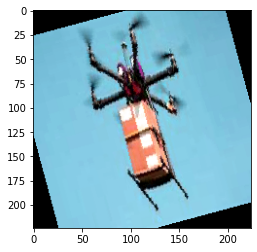

In [18]:
import numpy as np
plt.imshow((np.transpose((sample['total_drones'].cpu().detach().numpy()),(1,2,0))))
print((sample['labels']))
print(len(tot_drones['drones']))

In [19]:
SEED = 1
torch.cuda.empty_cache()
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED) 

def my_collate(batch):
    data={}
    data['total_drones'] = [(item['total_drones']) for item in batch]
    data['total_drones'] = (torch.Tensor(data['total_drones'][0])).unsqueeze(dim=0)
    data['labels'] = [item['labels'] for item in batch]
    data['labels'] = torch.LongTensor(data['labels'])
    
   # return [data['total_drones'], data['labels']]
    return data
train_dataset, valid_dataset = torch.utils.data.random_split(final_dataset, (10000, 7217))  

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                          shuffle=True, num_workers=2,collate_fn=my_collate)
testloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1,
                                         shuffle=False, num_workers=2,collate_fn=my_collate)
#trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
#                                          shuffle=True, num_workers=2,)
#testloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16,
#                                         shuffle=False, num_workers=2)


CUDA Available? True


In [ ]:
img=next(iter(trainloader))

In [ ]:
img['labels']

tensor([2, 3, 0, 2, 0, 1, 3, 2, 2, 3])

In [ ]:
img['total_drones'].size()

torch.Size([1, 3, 224, 224])

In [20]:
from tqdm import tqdm
loss_1=[]
loss_2=[]
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  cri = nn.CrossEntropyLoss()
  #cri=nn.MSELoss()
  for batch_idx, data in enumerate(pbar):
    # get samples
    data['total_drones'] = data['total_drones'].to(device)
    data['labels'] = data['labels'].to(device)


    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data['total_drones'])
    #y_pred = model(data['fgbg'])
   
    # Calculate loss

    loss=cri(y_pred,data['labels'])
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(data['labels'].view_as(pred)).sum().item()
    processed += len(data['total_drones'])
    
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    map=[]
    test_loss = 0
    correct = 0
    cri =  nn.CrossEntropyLoss()
    with torch.no_grad():
        for data in test_loader:
            data['total_drones'] = data['total_drones'].to(device)
            data['labels'] = data['labels'].to(device)

            output= model(data['total_drones'])
            
            loss=cri(output,data['labels'])
          
            test_loss += loss.item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(data['labels'].view_as(pred)).sum().item()
    
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
  
   

In [ ]:
from torch.optim.lr_scheduler import StepLR
#tqdm._instances.clear()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.90,weight_decay=0.001)
#optimizer=optim.Adam(model.parameters(), lr=0.055, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
scheduler=StepLR(optimizer,step_size=5,gamma=0.1)


EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)
    scheduler.step()

In [ ]:
data=(next(iter(testloader)))
model.to('cuda')
out=model(data['total_drones'].to('cuda')) 

In [ ]:
pred = out.argmax(dim=1, keepdim=True)

In [ ]:
#torch.save(model.state_dict(),'Mobilenet.pt')
torch.save(model,'Mobilenet.pt')

In [ ]:
device = torch.device('cuda')
model.load_state_dict(torch.load('Mobilenet.pt', map_location=device))

<All keys matched successfully>

In [ ]:
k=nn.Softmax(dim=1)


In [ ]:
len(final)

40

In [ ]:
torch.load('Mobilenet.pt')

In [ ]:
final=torch.eq(data['labels'].to('cpu'),pred.squeeze().to('cpu'))
images_out=[]
title_out=[]
for i in range(len(final)):
 
  if final[i].item() == False:
   images_out.append(np.transpose(data['total_drones'][i].cpu().detach().numpy(),(1,2,0))) 
   title_out.append(pred[i][0].item())
  

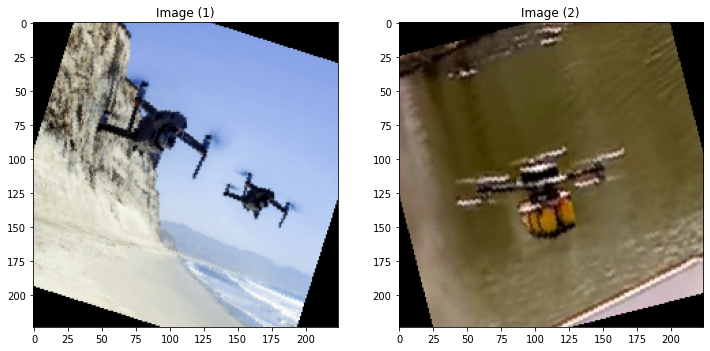

In [ ]:
show_images(images_out) 

In [ ]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()